# **Import Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

# **Data Loading**

In [ ]:
# Path to the zip file
#zip_path = '/content/drive/MyDrive/skeleton_bin_data.zip'
# Destination folder
#output_dir = '/content/drive/MyDrive/skeleton_bin_data'

# Create output directory if it doesn't exist
#os.makedirs(output_dir, exist_ok=True)

# Unzipping the file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(output_dir)

#print(f"Data unzipped to {output_dir}")

Data unzipped to /content/drive/MyDrive/skeleton_bin_data


In [ ]:
# Path to your dataset
dataset_path = Path("/content/drive/MyDrive/skeleton_bin_data/Données/d1-27-12")
images_path = dataset_path / "ori"
skeleton_path = dataset_path / "skeleton"

## *Helper Function to Walk Through Directories*

In [ ]:
# Function to walk through directories
def walk_through_dir(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        print(f'Found {len(filenames)} images in {dirpath}')
        break

# Walk through images and masks directories
walk_through_dir(images_path)
walk_through_dir(skeleton_path)

Found 256 images in /content/drive/MyDrive/skeleton_bin_data/Données/d1-27-12/ori
Found 256 images in /content/drive/MyDrive/skeleton_bin_data/Données/d1-27-12/skeleton


## *Helper Class for Data Loading*

In [ ]:
class PoreSegmentationDataset(Dataset):
    def __init__(self, image_paths, skeleton_path, transform=None):
        self.image_paths = image_paths
        self.skeleton_path = skeleton_path
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image and skeleton
            image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
            skeleton = Image.open(self.skeleton_path[idx]).convert("L")  # Grayscale
        except Exception as e:
            raise RuntimeError(f"Error loading image or skeleton : {e}")

        # Convert to tensors and normalize
        image = ToTensor()(image)  # Convert to Tensor and normalize to [0, 1]
        skeleton = ToTensor()(skeleton).float()  # Convert to Tensor and normalize to [0, 1]

        # Ensure binary masks
        skeleton = (skeleton > 0.5).float()  # Threshold to binary (0 or 1)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            skeleton = self.transform(skeleton)

        return image, skeleton

# **Load and Transform Data**

In [ ]:
import re

In [ ]:
# Define a function to extract the numeric part of a filename
def extract_number(path):
    match = re.search(r'(\d+)', path.name)
    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

# Sort paths numerically
image_paths = sorted(images_path.glob("*.png"), key=extract_number)
skeleton_paths = sorted(skeleton_path.glob("*.png"), key=extract_number)

In [ ]:
# Split into train, validation, and test sets
train_image_paths, test_image_paths, train_skeleton_paths, test_skeleton_paths = train_test_split(
    image_paths, skeleton_paths, test_size=0.2
)
train_image_paths, val_image_paths, train_skeleton_paths, val_skeleton_paths = train_test_split(
    train_image_paths, train_skeleton_paths, test_size=0.2
)

# Create datasets
train_dataset = PoreSegmentationDataset(train_image_paths, train_skeleton_paths)
val_dataset = PoreSegmentationDataset(val_image_paths, val_skeleton_paths)
test_dataset = PoreSegmentationDataset(test_image_paths, test_skeleton_paths)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 163
Validation dataset size: 41
Test dataset size: 52


## *Visualizing a Random Sample*

In [ ]:
import torchvision.transforms as T
import random

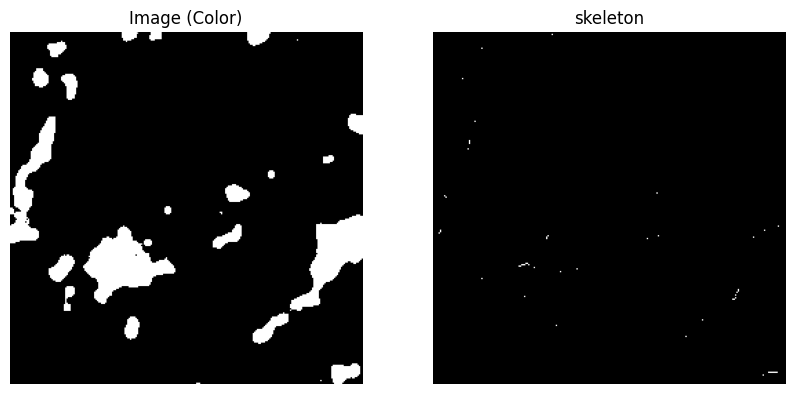

In [ ]:
# Function to display a random image and its mask
def display_random_image_with_skeleton(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and skeleton
    image, skeleton = dataset[idx]

    # If tensors, convert to PIL for visualization
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    if isinstance(skeleton, torch.Tensor):
        skeleton = T.ToPILImage()(skeleton)

    # Display the image and mask
    plt.figure(figsize=(10, 5))

    # Display image in color
    plt.subplot(1, 2, 1)
    plt.imshow(image,cmap="gray")  # Displays image in GrayScale
    plt.title("Image (Color)")
    plt.axis("off")

    # Display skeleton
    plt.subplot(1, 2, 2)
    plt.imshow(skeleton, cmap="gray")
    plt.title("skeleton")
    plt.axis("off")

    plt.show()

# Display random image with skeleton from training dataset
display_random_image_with_skeleton(train_dataset)

# **Model (UNet Architecture)**

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.upsample_to_input = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec1 = self.upconv1(enc4)
        dec2 = self.upconv2(dec1 + enc3)
        dec3 = self.upconv3(dec2 + enc2)

        final = self.final(dec3 + enc1)

        if final.shape[-2:] != x.shape[-2:]:
            final = self.upsample_to_input(final)

        return final

# **Loss Functions**

In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=True)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    return 1 - dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# **Model Training**

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, skeleton in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, skeleton = images.to(device), skeleton.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = dice_loss(outputs, skeleton)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for images, skeleton in val_loader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)

            val_loss += dice_loss(outputs, skeleton).item()
            iou += iou_score(outputs, skeleton).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/100: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Epoch 1: Train Loss: 0.9958207932385531
Validation Loss: 0.9967027902603149, IoU Score: 0.004227707007278998


Epoch 2/100: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 2: Train Loss: 0.9941966425288807
Validation Loss: 0.9945191740989685, IoU Score: 0.005955270336320003


Epoch 3/100: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch 3: Train Loss: 0.9926935651085593
Validation Loss: 0.9927881360054016, IoU Score: 0.00791117362678051


Epoch 4/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 4: Train Loss: 0.990931364622983
Validation Loss: 0.9915246367454529, IoU Score: 0.008451831837495169


Epoch 5/100: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 5: Train Loss: 0.9886643561449918
Validation Loss: 0.9881172974904379, IoU Score: 0.010193681033949057


Epoch 6/100: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 6: Train Loss: 0.9854945106939836
Validation Loss: 0.9851094086964926, IoU Score: 0.022683824102083843


Epoch 7/100: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 7: Train Loss: 0.9772987094792452
Validation Loss: 0.9682410756746928, IoU Score: 0.029619840284188587


Epoch 8/100: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch 8: Train Loss: 0.9654588645154779
Validation Loss: 0.9605986475944519, IoU Score: 0.040671673913796745


Epoch 9/100: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]


Epoch 9: Train Loss: 0.9493975043296814
Validation Loss: 0.9568615158398946, IoU Score: 0.030928903569777805


Epoch 10/100: 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch 10: Train Loss: 0.9322178038683805
Validation Loss: 0.9503652652104696, IoU Score: 0.02820638194680214


Epoch 11/100: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 11: Train Loss: 0.9211003509434786
Validation Loss: 0.9176474014918009, IoU Score: 0.054448398451010384


Epoch 12/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 12: Train Loss: 0.9075677719983187
Validation Loss: 0.916512131690979, IoU Score: 0.05301147699356079


Epoch 13/100: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch 13: Train Loss: 0.8942018422213468
Validation Loss: 0.91538139184316, IoU Score: 0.050673820078372955


Epoch 14/100: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 14: Train Loss: 0.8883243582465432
Validation Loss: 0.9110798835754395, IoU Score: 0.05147389570871989


Epoch 15/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 15: Train Loss: 0.8742625550790266
Validation Loss: 0.9279847939809164, IoU Score: 0.03855609272917112


Epoch 16/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 16: Train Loss: 0.8701675425876271
Validation Loss: 0.9085627794265747, IoU Score: 0.05206931009888649


Epoch 17/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 17: Train Loss: 0.8628274364904924
Validation Loss: 0.9149791797002157, IoU Score: 0.04729954650004705


Epoch 18/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 18: Train Loss: 0.874824193390933
Validation Loss: 0.90813148021698, IoU Score: 0.05361550177137057


Epoch 19/100: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 19: Train Loss: 0.8584353761239485
Validation Loss: 0.9093301296234131, IoU Score: 0.050628441075483956


Epoch 20/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 20: Train Loss: 0.8490171757611361
Validation Loss: 0.9065550764401754, IoU Score: 0.0525515154004097


Epoch 21/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 21: Train Loss: 0.8594253442504189
Validation Loss: 0.9098358154296875, IoU Score: 0.05150926858186722


Epoch 22/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 22: Train Loss: 0.8504705320705067
Validation Loss: 0.9019863605499268, IoU Score: 0.05474839235345522


Epoch 23/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 23: Train Loss: 0.828850507736206
Validation Loss: 0.9272844990094503, IoU Score: 0.03916588053107262


Epoch 24/100: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s]


Epoch 24: Train Loss: 0.8290439681573347
Validation Loss: 0.9259182214736938, IoU Score: 0.03923844794432322


Epoch 25/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 25: Train Loss: 0.8149273232980208
Validation Loss: 0.9181119998296102, IoU Score: 0.04531244561076164


Epoch 26/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 26: Train Loss: 0.8036694147370078
Validation Loss: 0.9183022777239481, IoU Score: 0.04258685062328974


Epoch 27/100: 100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 27: Train Loss: 0.80618971044367
Validation Loss: 0.9093573888142904, IoU Score: 0.04805165777603785


Epoch 28/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 28: Train Loss: 0.7972792061892423
Validation Loss: 0.9132187962532043, IoU Score: 0.0449704093237718


Epoch 29/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 29: Train Loss: 0.7922726219350641
Validation Loss: 0.892838696638743, IoU Score: 0.059065392861763634


Epoch 30/100: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch 30: Train Loss: 0.7860149253498424
Validation Loss: 0.9544499516487122, IoU Score: 0.021861712137858074


Epoch 31/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 31: Train Loss: 0.7942176352847706
Validation Loss: 0.8905553619066874, IoU Score: 0.06196333095431328


Epoch 32/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 32: Train Loss: 0.7706737409938466
Validation Loss: 0.9041172464688619, IoU Score: 0.053636653969685234


Epoch 33/100: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


Epoch 33: Train Loss: 0.7678232301365245
Validation Loss: 0.8972050944964091, IoU Score: 0.05689487854639689


Epoch 34/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 34: Train Loss: 0.7658539793708108
Validation Loss: 0.8983235756556193, IoU Score: 0.055123565097649894


Epoch 35/100: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 35: Train Loss: 0.7576573545282538
Validation Loss: 0.9210029641787211, IoU Score: 0.04090582331021627


Epoch 36/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 36: Train Loss: 0.7350574840198864
Validation Loss: 0.9010101358095804, IoU Score: 0.05368746196230253


Epoch 37/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 37: Train Loss: 0.735307211225683
Validation Loss: 0.9108257095019022, IoU Score: 0.047019372383753456


Epoch 38/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 38: Train Loss: 0.7479331005703319
Validation Loss: 0.9029994209607443, IoU Score: 0.052216206987698875


Epoch 39/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 39: Train Loss: 0.7345413023775275
Validation Loss: 0.9112231731414795, IoU Score: 0.048425376415252686


Epoch 40/100: 100%|██████████| 11/11 [00:04<00:00,  2.65it/s]


Epoch 40: Train Loss: 0.7277371720834211
Validation Loss: 0.9048658609390259, IoU Score: 0.052554683138926826


Epoch 41/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 41: Train Loss: 0.7136273871768605
Validation Loss: 0.9122271339098612, IoU Score: 0.04842484990755717


Epoch 42/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 42: Train Loss: 0.7333309867165305
Validation Loss: 0.9193574786186218, IoU Score: 0.04300296182433764


Epoch 43/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 43: Train Loss: 0.7249631935899908
Validation Loss: 0.8995188474655151, IoU Score: 0.05506399149696032


Epoch 44/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 44: Train Loss: 0.7101890878243879
Validation Loss: 0.9202618400255839, IoU Score: 0.042434290051460266


Epoch 45/100: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 45: Train Loss: 0.7101339372721586
Validation Loss: 0.9167984326680502, IoU Score: 0.04692474380135536


Epoch 46/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 46: Train Loss: 0.7110982266339388
Validation Loss: 0.9084168871243795, IoU Score: 0.05102756495277087


Epoch 47/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 47: Train Loss: 0.7034222700379111
Validation Loss: 0.9049836993217468, IoU Score: 0.05124263217051824


Epoch 48/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 48: Train Loss: 0.7022011442617937
Validation Loss: 0.8989807566006979, IoU Score: 0.054433693488438926


Epoch 49/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 49: Train Loss: 0.6922001080079512
Validation Loss: 0.9241140087445577, IoU Score: 0.03922748068968455


Epoch 50/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 50: Train Loss: 0.6872734535824169
Validation Loss: 0.9071316719055176, IoU Score: 0.049123273541529976


Epoch 51/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 51: Train Loss: 0.6875339367172935
Validation Loss: 0.9113855163256327, IoU Score: 0.0467441293100516


Epoch 52/100: 100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 52: Train Loss: 0.6701793941584501
Validation Loss: 0.9038594166437784, IoU Score: 0.05260154729088148


Epoch 53/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 53: Train Loss: 0.6778037006204779
Validation Loss: 0.9184663494427999, IoU Score: 0.04291163260738055


Epoch 54/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 54: Train Loss: 0.6740320704200051
Validation Loss: 0.9041977127393087, IoU Score: 0.052190164724985756


Epoch 55/100: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 55: Train Loss: 0.6634913737123663
Validation Loss: 0.9193455179532369, IoU Score: 0.0431586392223835


Epoch 56/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 56: Train Loss: 0.674744801087813
Validation Loss: 0.9003403186798096, IoU Score: 0.05439015353719393


Epoch 57/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 57: Train Loss: 0.6721015897664157
Validation Loss: 0.9317331910133362, IoU Score: 0.03490213677287102


Epoch 58/100: 100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 58: Train Loss: 0.6635643406347795
Validation Loss: 0.9019235769907633, IoU Score: 0.0533231757581234


Epoch 59/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 59: Train Loss: 0.6558747887611389
Validation Loss: 0.9059085051218668, IoU Score: 0.051123328506946564


Epoch 60/100: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]


Epoch 60: Train Loss: 0.6701324094425548
Validation Loss: 0.9123211900393168, IoU Score: 0.04642610624432564


Epoch 61/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 61: Train Loss: 0.6721054857427423
Validation Loss: 0.9198059638341268, IoU Score: 0.04211171716451645


Epoch 62/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 62: Train Loss: 0.6413725885477933
Validation Loss: 0.9090698758761088, IoU Score: 0.05019242689013481


Epoch 63/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 63: Train Loss: 0.7145196036858992
Validation Loss: 0.9163989424705505, IoU Score: 0.04315036286910375


Epoch 64/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 64: Train Loss: 0.699903894554485
Validation Loss: 0.9144599040349325, IoU Score: 0.045080327739318214


Epoch 65/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 65: Train Loss: 0.6818084500052712
Validation Loss: 0.93724658091863, IoU Score: 0.03168222556511561


Epoch 66/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 66: Train Loss: 0.6702463247559287
Validation Loss: 0.9133072892824808, IoU Score: 0.04657410581906637


Epoch 67/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 67: Train Loss: 0.649891961704601
Validation Loss: 0.9103488326072693, IoU Score: 0.04681504021088282


Epoch 68/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 68: Train Loss: 0.6434289325367321
Validation Loss: 0.9068427681922913, IoU Score: 0.05050135403871536


Epoch 69/100: 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


Epoch 69: Train Loss: 0.639771434393796
Validation Loss: 0.9041537642478943, IoU Score: 0.05145654330650965


Epoch 70/100: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 70: Train Loss: 0.637965901331468
Validation Loss: 0.9032684167226156, IoU Score: 0.05281449854373932


Epoch 71/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 71: Train Loss: 0.6358690641143105
Validation Loss: 0.9103945096333822, IoU Score: 0.04674174884955088


Epoch 72/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 72: Train Loss: 0.6292281313375994
Validation Loss: 0.9169471859931946, IoU Score: 0.04649214322368304


Epoch 73/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 73: Train Loss: 0.6354949582706798
Validation Loss: 0.9069610039393107, IoU Score: 0.05110820631186167


Epoch 74/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 74: Train Loss: 0.6333136233416471
Validation Loss: 0.9013368089993795, IoU Score: 0.054502056290706


Epoch 75/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 75: Train Loss: 0.6301695812832225
Validation Loss: 0.9244250853856405, IoU Score: 0.03804739067951838


Epoch 76/100: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


Epoch 76: Train Loss: 0.6245249130509116
Validation Loss: 0.9125476280848185, IoU Score: 0.04546597848335902


Epoch 77/100: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 77: Train Loss: 0.6210281198674982
Validation Loss: 0.912907083829244, IoU Score: 0.047402391831080117


Epoch 78/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 78: Train Loss: 0.6224074526266619
Validation Loss: 0.9047180016835531, IoU Score: 0.052060638864835106


Epoch 79/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 79: Train Loss: 0.6283171502026644
Validation Loss: 0.8966034849484762, IoU Score: 0.05682825297117233


Epoch 80/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 80: Train Loss: 0.62842872467908
Validation Loss: 0.9029748837153116, IoU Score: 0.05216852327187856


Epoch 81/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 81: Train Loss: 0.6212830543518066
Validation Loss: 0.9008139769236246, IoU Score: 0.05529132733742396


Epoch 82/100: 100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 82: Train Loss: 0.6182100339369341
Validation Loss: 0.9088696042696635, IoU Score: 0.05182730406522751


Epoch 83/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 83: Train Loss: 0.6122179302302274
Validation Loss: 0.9028940399487814, IoU Score: 0.05255271246035894


Epoch 84/100: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Epoch 84: Train Loss: 0.6177288727326826
Validation Loss: 0.9206246733665466, IoU Score: 0.043169472366571426


Epoch 85/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 85: Train Loss: 0.621727938001806
Validation Loss: 0.9206674695014954, IoU Score: 0.04108047361175219


Epoch 86/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 86: Train Loss: 0.6230412233959545
Validation Loss: 0.9084368546803793, IoU Score: 0.04873029639323553


Epoch 87/100: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 87: Train Loss: 0.6177800839597528
Validation Loss: 0.9173213243484497, IoU Score: 0.04497022554278374


Epoch 88/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 88: Train Loss: 0.6044975844296542
Validation Loss: 0.9116575717926025, IoU Score: 0.046348253885904946


Epoch 89/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 89: Train Loss: 0.5992666808041659
Validation Loss: 0.9171250065167745, IoU Score: 0.04427188138167063


Epoch 90/100: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 90: Train Loss: 0.6037001338872042
Validation Loss: 0.9193801482518514, IoU Score: 0.041478815178076424


Epoch 91/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 91: Train Loss: 0.6004840569062666
Validation Loss: 0.9196802973747253, IoU Score: 0.043923849860827126


Epoch 92/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 92: Train Loss: 0.6078036319125782
Validation Loss: 0.9217573801676432, IoU Score: 0.041816910107930504


Epoch 93/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 93: Train Loss: 0.6013050241903826
Validation Loss: 0.9138418436050415, IoU Score: 0.04683218648036321


Epoch 94/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 94: Train Loss: 0.6010923168875955
Validation Loss: 0.9116920232772827, IoU Score: 0.04859675342837969


Epoch 95/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 95: Train Loss: 0.5979219620878046
Validation Loss: 0.911362906297048, IoU Score: 0.0485017883280913


Epoch 96/100: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 96: Train Loss: 0.5925479314543984
Validation Loss: 0.9150850176811218, IoU Score: 0.04339239994684855


Epoch 97/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 97: Train Loss: 0.5969319560311057
Validation Loss: 0.9144464532534281, IoU Score: 0.04436439027388891


Epoch 98/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 98: Train Loss: 0.5915561643513766
Validation Loss: 0.9221668044726054, IoU Score: 0.040342157085736595


Epoch 99/100: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 99: Train Loss: 0.602323748848655
Validation Loss: 0.9214988350868225, IoU Score: 0.042537314196427665


Epoch 100/100: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 100: Train Loss: 0.599741664799777
Validation Loss: 0.9192881981531779, IoU Score: 0.04250108326474825


## *Save the Model & Training History*

In [ ]:
# Define the model save path
model_save_dir = "/content/drive/MyDrive/Skeleton_Trained_Model_2D"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
def save_model(model, model_save_dir):
    model_path = os.path.join(model_save_dir, "model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

# Call the function to save the model
save_model(model, model_save_dir)

Model saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/model.pth


In [ ]:
import pickle

# Save the training history (as a pickle file)
history_path = os.path.join(model_save_dir, "history.pkl")
with open(history_path, 'wb') as history_file:
    pickle.dump(history, history_file)
print(f"History saved at {history_path}")

History saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/history.pkl


## *Load the Model & Training History*

In [ ]:
# Define the model instance
model = UNet(in_channels=1, out_channels=1)  # Example for input RGB images and binary segmentation output
model.load_state_dict(torch.load(model_save_dir+"/model.pth"))

# If using GPU, move the model to the correct device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Load the history
with open(os.path.join(model_save_dir, "history.pkl"), 'rb') as history_file:
    history = pickle.load(history_file)

print("Model and history loaded successfully!")

## *Visualize the Training History*

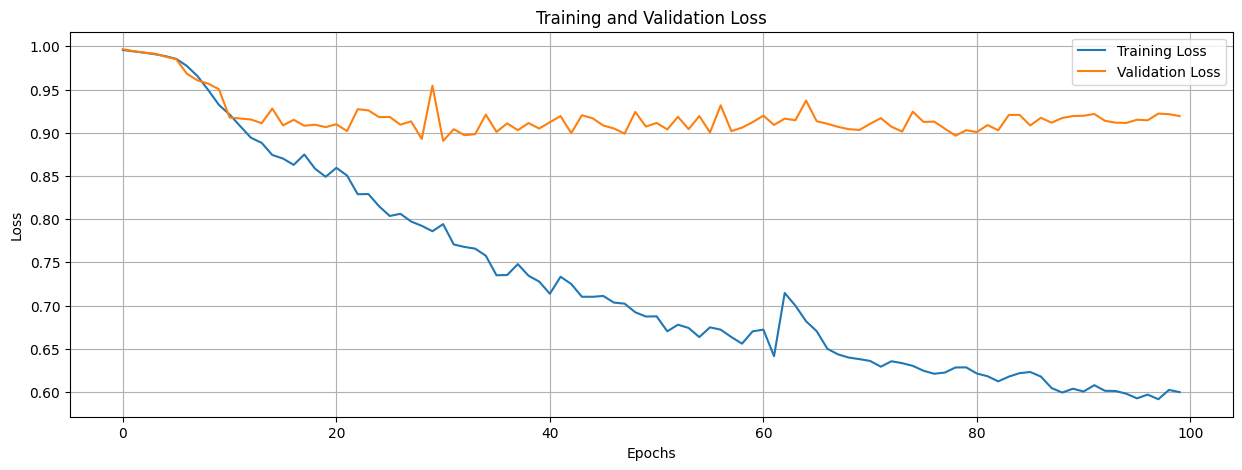

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

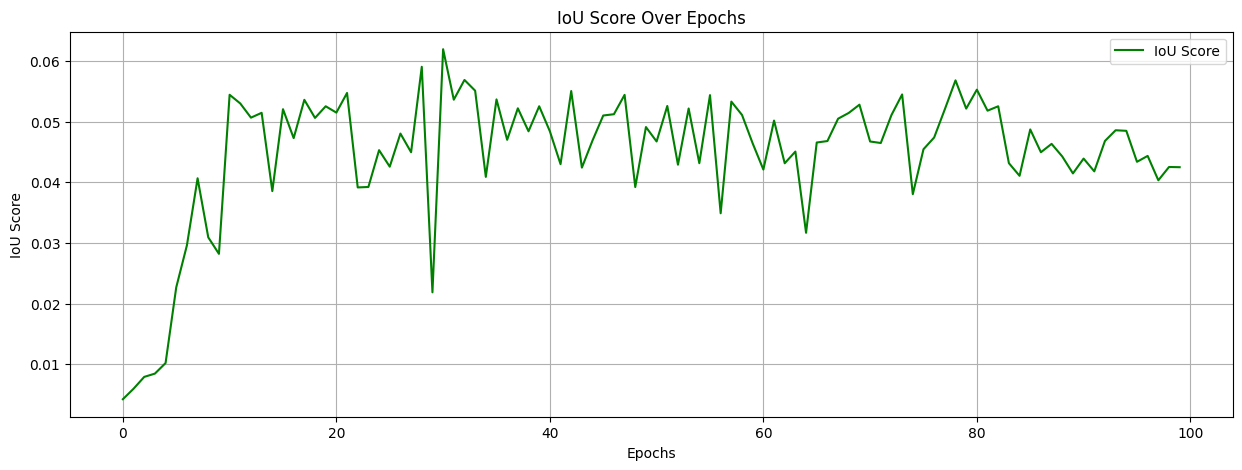

In [ ]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Evaluate the Model**

## *Validation and Testing*

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

# Evaluate model on test dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, skeleton in dataloader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)
            preds = (outputs.sigmoid() > threshold).float()

            for pred, skeleton in zip(preds, skeleton):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), skeleton.cpu().numpy()))
                iou_scores.append(iou(pred.cpu().numpy(), skeleton.cpu().numpy()))
                precisions.append(precision_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                recalls.append(recall_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                f1s.append(f1_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"IoU: {np.mean(iou_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")

In [ ]:
evaluate_model(model, test_loader)

Dice Coefficient: 0.0643
IoU: 0.0339
Precision: 0.1307
Recall: 0.0441
F1 Score: 0.0643


## *Error Analysis*

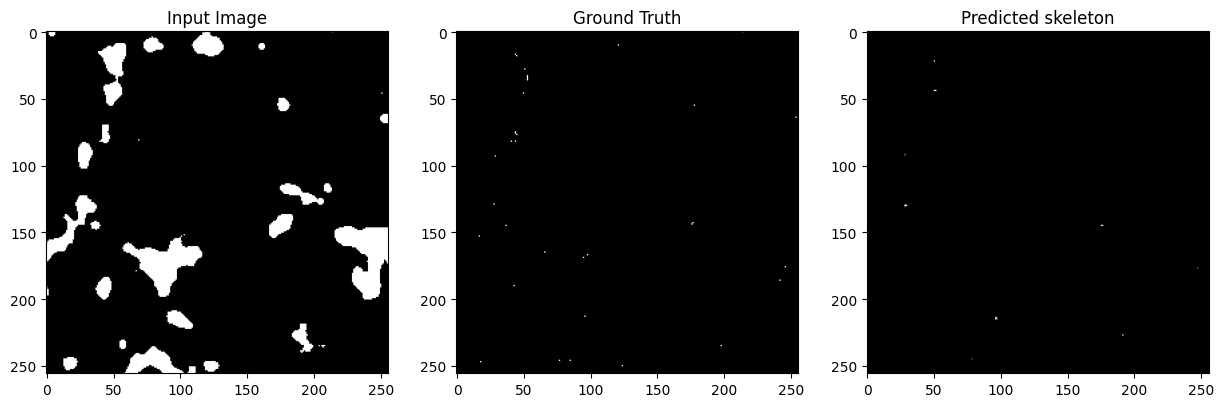

In [ ]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, skeleton in test_loader:
        # Move images and masks to the device
        images, skeleton = images.to(device), skeleton.to(device)

        # Get the model outputs
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid and move to CPU
        outputs = (outputs * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

        images = images.cpu().numpy()
        skeleton = skeleton.cpu().numpy()

        # Visualize the input image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))

        # Input image (grayscale)
        axes[0].imshow(images[0, 0], cmap='gray')
        axes[0].set_title("Input Image")

        # Ground truth mask (binary, scaled to [0, 255] for visualization)
        axes[1].imshow(skeleton[0, 0], cmap='gray')
        axes[1].set_title("Ground Truth")

        # Predicted mask (scaled to [0, 255])
        axes[2].imshow(outputs[0, 0], cmap='gray')
        axes[2].set_title("Predicted skeleton")

        # Display the visualization
        plt.show()

        break

# **Interpret Results**

# **Step 1: Organize The Data**

In [3]:
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.transform import resize
import re
import torch.optim as optim
from tqdm import tqdm

In [4]:
data_path = Path("/content/drive/MyDrive/data_skeleton")

In [5]:
# Define a function to extract the numeric part of a filename
def extract_number(path):

    match = re.search(r'(\d+)', path.name)

    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

In [7]:
def load_volume_from_folder(base_path, target_depth):
    """
    Load and resize the first `target_depth` slices of a volume from the given folder.
    """
    image_slices = sorted((base_path / "ori").glob("*.png"), key=extract_number)[:target_depth]
    skeleton_slices = sorted((base_path / "skeleton").glob("*.png"), key=extract_number)[:target_depth]

    image_volume = np.stack([
        resize(
            np.array(Image.open(img).convert("L")),
            target_shape[1:],  # Resize to target height and width
            preserve_range=True,
            anti_aliasing=True,
        ) for img in image_slices
    ], axis=0)

    skeleton_volume = np.stack([
        resize(
            np.array(Image.open(skl).convert("L")),
            target_shape[1:],  # Resize to target height and width
            preserve_range=True,
            anti_aliasing=True,
        ) for skl in skeleton_slices
    ], axis=0)

    return image_volume, skeleton_volume

In [8]:
# Define the target shape for each volume (depth, height, width)
target_shape = (64, 256, 256)  # 64 slices of 256x256 images

image_volumes = []
skeleton_volumes = []

# Iterate over folders and load volumes
for i, folder in enumerate(tqdm(data_path.iterdir(), desc="Processing Folders"), start=1):
    if folder.is_dir():
        images, skeletons = load_volume_from_folder(folder, target_shape[0])  # Pass the target depth
        image_volumes.append(images)
        skeleton_volumes.append(skeletons)

        if i == 5:  # Process only the first 5 folders
            break

Processing Folders: 4it [04:51, 72.97s/it]


In [9]:
# Convert lists to numpy arrays for convenience
image_volumes = np.array(image_volumes)
skeleton_volumes = np.array(skeleton_volumes)

In [10]:
print(f"Image Volumes Shape: {image_volumes.shape}")
print(f"Image Volumes Data Type: {image_volumes.dtype}")

print(f"Skeleton Volumes Shape: {skeleton_volumes.shape}")
print(f"Skeleton Volumes Data Type: {skeleton_volumes.dtype}")

Image Volumes Shape: (5, 64, 256, 256)
Image Volumes Data Type: float64
Skeleton Volumes Shape: (5, 64, 256, 256)
Skeleton Volumes Data Type: float64


# **Step 2: Prepare Dataset for PyTorch**

In [11]:
import torch
from torch.utils.data import Dataset

In [12]:
class PoreSegmentation3DDataset(Dataset):
    def __init__(self, images, skeletons, transform=None):
        self.images = images
        self.skeletons = skeletons
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        skeleton = self.skeletons[idx]

        # Convert to tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize the image
        skeleton = torch.tensor(skeleton, dtype=torch.float32) / 255.0  # Normalize the skeleton

        # Ensure binary masks
        skeleton = (skeleton > 0.5).float()

        # Add channel dimension (C, D, H, W) -> (1, 64, 256, 256)
        image = image.unsqueeze(0)  # Add channel dimension: (1, 64, 256, 256)
        skeleton = skeleton.unsqueeze(0)  # Add channel dimension: (1, 64, 256, 256)

        return image, skeleton

# **Step 3: Split Data**

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split the data into train, validation, and test sets
train_images, test_images, train_skeletons, test_skeletons = train_test_split(image_volumes, skeleton_volumes, test_size=0.2)

train_images, val_images, train_skeletons, val_skeletons = train_test_split(train_images, train_skeletons, test_size=0.2)

# Create Dataset objects
train_dataset = PoreSegmentation3DDataset(train_images, train_skeletons)
val_dataset = PoreSegmentation3DDataset(val_images, val_skeletons)
test_dataset = PoreSegmentation3DDataset(test_images, test_skeletons)

# Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
# Test the data loader
for volumes, skeletons in train_loader:
    print("Input Shape",volumes.shape)  # Expected shape: torch.Size([1, 1, 64, 256, 256])
    print("Skeleton Shape", skeletons.shape)
    break

Input Shape torch.Size([1, 1, 64, 256, 256])
Skeleton Shape torch.Size([1, 1, 64, 256, 256])


# **Step 4: Build the 3D U-Net**

In [16]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool3d(2)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Decoding with skip connections
        dec1 = self.upconv1(enc4)
        dec1 = dec1 + enc3  # Skip connection
        dec2 = self.upconv2(dec1)
        dec2 = dec2 + enc2  # Skip connection
        dec3 = self.upconv3(dec2)
        dec3 = dec3 + enc1  # Skip connection

        final = self.final(dec3)
        return final

# **Step 5: Train the Model**

In [29]:
def dice_loss(pred, target, smooth=1e-6, foreground_weight=0.95, background_weight=0.05):
    # Apply sigmoid activation to the predictions
    pred = torch.sigmoid(pred)

    # Interpolate target to match pred shape
    target = torch.nn.functional.interpolate(target, size=pred.shape[2:], mode="trilinear", align_corners=True)

    # Flatten for Dice loss computation
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    # Calculate the intersection, sum of predictions, and sum of targets
    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    # Apply weights: foreground gets a higher weight, background gets a lower weight
    weighted_dice = foreground_weight * dice * target.mean() + background_weight * dice * (1 - target.mean())

    return 1 - weighted_dice.mean()

def iou_score(pred, target, smooth=1e-6):
    """
    IoU Score for 3D volumetric skeleton data.
    """
    pred = torch.sigmoid(pred)  # Apply sigmoid
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3, 4))  # Adjust for 3D (B, D, H, W)
    union = pred.sum(dim=(1, 2, 3, 4)) + target.sum(dim=(1, 2, 3, 4)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [30]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust UNet for 3D input and output channels
model = UNet3D(1, 1).to(device)  # Replace `UNet` with a 3D version like `UNet3D`
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for volumes, skeletons in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        volumes, skeletons = volumes.to(device), skeletons.to(device)

        optimizer.zero_grad()

        outputs = model(volumes)

        #print(f"Pred shape: {outputs.shape}, Target shape: {skeletons.shape}")

        loss = dice_loss(outputs, skeletons)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for volumes, skeletons in val_loader:
            volumes, skeletons = volumes.to(device), skeletons.to(device)
            outputs = model(volumes)

            val_loss += dice_loss(outputs, skeletons).item()
            iou += iou_score(outputs, skeletons).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 1: Train Loss: 0.9999728202819824
Validation Loss: 0.9999994039535522, IoU Score: 1.9349514332134277e-05


Epoch 2/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 2: Train Loss: 0.9999459385871887
Validation Loss: 0.9999992251396179, IoU Score: 1.016625901684165e-05


Epoch 3/100: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


Epoch 3: Train Loss: 0.9999376138051351
Validation Loss: 0.9999994039535522, IoU Score: 6.594460501219146e-06


Epoch 4/100: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


Epoch 4: Train Loss: 0.9999317328135172
Validation Loss: 0.9999994039535522, IoU Score: 6.796280104026664e-06


Epoch 5/100: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


Epoch 5: Train Loss: 0.9999253352483114
Validation Loss: 0.9999993443489075, IoU Score: 7.418578661599895e-06


Epoch 6/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 6: Train Loss: 0.9999218583106995
Validation Loss: 0.9999992251396179, IoU Score: 9.474328180658631e-06


Epoch 7/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 7: Train Loss: 0.9999183019002279
Validation Loss: 0.9999990463256836, IoU Score: 1.3250953088572714e-05


Epoch 8/100: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Epoch 8: Train Loss: 0.9999153216679891
Validation Loss: 0.9999988079071045, IoU Score: 2.1622481654048897e-05


Epoch 9/100: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


Epoch 9: Train Loss: 0.999911367893219
Validation Loss: 0.9999986886978149, IoU Score: 2.3594151571160182e-05


Epoch 10/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 10: Train Loss: 0.9999066591262817
Validation Loss: 0.9999985098838806, IoU Score: 2.6567875465843827e-05


Epoch 11/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 11: Train Loss: 0.9999045530954996
Validation Loss: 0.9999980926513672, IoU Score: 3.986102092312649e-05


Epoch 12/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 12: Train Loss: 0.9999017715454102
Validation Loss: 0.9999986290931702, IoU Score: 2.0355913875391707e-05


Epoch 13/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 13: Train Loss: 0.9998974601427714
Validation Loss: 0.9999991059303284, IoU Score: 1.0292985280102585e-05


Epoch 14/100: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


Epoch 14: Train Loss: 0.9998966058095297
Validation Loss: 0.9999988675117493, IoU Score: 1.3733750165556557e-05


Epoch 15/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 15: Train Loss: 0.9998910625775655
Validation Loss: 0.9999982714653015, IoU Score: 2.5853156330413185e-05


Epoch 16/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 16: Train Loss: 0.9998855392138163
Validation Loss: 0.999997615814209, IoU Score: 4.4781583710573614e-05


Epoch 17/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 17: Train Loss: 0.9998804926872253
Validation Loss: 0.9999973177909851, IoU Score: 5.5660355428699404e-05


Epoch 18/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 18: Train Loss: 0.999882161617279
Validation Loss: 0.9999971985816956, IoU Score: 5.8457317209104076e-05


Epoch 19/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 19: Train Loss: 0.9998698830604553
Validation Loss: 0.999997079372406, IoU Score: 7.217669917736202e-05


Epoch 20/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 20: Train Loss: 0.9998643199602762
Validation Loss: 0.9999969005584717, IoU Score: 0.00010680275590857491


Epoch 21/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 21: Train Loss: 0.9998581806818644
Validation Loss: 0.9999969601631165, IoU Score: 0.0001457643520552665


Epoch 22/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 22: Train Loss: 0.9998536904652914
Validation Loss: 0.9999974966049194, IoU Score: 0.00010616025247145444


Epoch 23/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 23: Train Loss: 0.9998641014099121
Validation Loss: 0.9999973177909851, IoU Score: 3.982776979682967e-05


Epoch 24/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 24: Train Loss: 0.9998517235120138
Validation Loss: 0.9999971985816956, IoU Score: 3.567118619685061e-05


Epoch 25/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 25: Train Loss: 0.9998504916826884
Validation Loss: 0.9999955892562866, IoU Score: 6.483869947260246e-05


Epoch 26/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 26: Train Loss: 0.9998438954353333
Validation Loss: 0.9999944567680359, IoU Score: 9.99089825199917e-05


Epoch 27/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 27: Train Loss: 0.9998334447542826
Validation Loss: 0.9999940991401672, IoU Score: 0.00013827435031998903


Epoch 28/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 28: Train Loss: 0.9998275438944498
Validation Loss: 0.9999969005584717, IoU Score: 0.00019403244368731976


Epoch 29/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 29: Train Loss: 0.9998139142990112
Validation Loss: 0.9999945759773254, IoU Score: 0.0002192381798522547


Epoch 30/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 30: Train Loss: 0.9998266696929932
Validation Loss: 0.999997079372406, IoU Score: 0.0001928587444126606


Epoch 31/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 31: Train Loss: 0.999801754951477
Validation Loss: 0.9999998211860657, IoU Score: 3.271929949200114e-11


Epoch 32/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 32: Train Loss: 0.9998001853624979
Validation Loss: 0.9999995231628418, IoU Score: 4.425370570970699e-05


Epoch 33/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 33: Train Loss: 0.9997799595197042
Validation Loss: 1.0, IoU Score: 1.426533557946641e-09


Epoch 34/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 34: Train Loss: 0.999791145324707
Validation Loss: 0.9999969005584717, IoU Score: 4.391368929645978e-05


Epoch 35/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 35: Train Loss: 0.9998142917950948
Validation Loss: 0.9999961256980896, IoU Score: 5.235298158368096e-05


Epoch 36/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 36: Train Loss: 0.9998206893603007
Validation Loss: 0.9999943971633911, IoU Score: 8.338893530890346e-05


Epoch 37/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 37: Train Loss: 0.9998182853062948
Validation Loss: 0.9999914169311523, IoU Score: 0.0001983640977414325


Epoch 38/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 38: Train Loss: 0.9998029073079427
Validation Loss: 0.9999954700469971, IoU Score: 0.0003553408314473927


Epoch 39/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 39: Train Loss: 0.9997778534889221
Validation Loss: 0.9999958276748657, IoU Score: 0.0002645853965077549


Epoch 40/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 40: Train Loss: 0.999753733476003
Validation Loss: 0.9999943375587463, IoU Score: 0.000153666507685557


Epoch 41/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 41: Train Loss: 0.9997049967447916
Validation Loss: 0.9999988079071045, IoU Score: 2.849002811444734e-09


Epoch 42/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 42: Train Loss: 0.9998575846354166
Validation Loss: 0.9999995827674866, IoU Score: 5.2631573765893336e-08


Epoch 43/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 43: Train Loss: 0.9997186462084452
Validation Loss: 1.0, IoU Score: 4.655710192369433e-11


Epoch 44/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 44: Train Loss: 0.999688982963562
Validation Loss: 1.0, IoU Score: 1.3859822144135503e-11


Epoch 45/100: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


Epoch 45: Train Loss: 0.9996757109959921
Validation Loss: 1.0, IoU Score: 1.8857250483339527e-10


Epoch 46/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 46: Train Loss: 0.9996261199315389
Validation Loss: 1.0, IoU Score: 1.1277771772011391e-10


Epoch 47/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 47: Train Loss: 0.9995661775271097
Validation Loss: 1.0, IoU Score: 1.8996960948758357e-10


Epoch 48/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 48: Train Loss: 0.9996523857116699
Validation Loss: 1.0, IoU Score: 2.374168917018693e-10


Epoch 49/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 49: Train Loss: 0.9995717406272888
Validation Loss: 1.0, IoU Score: 3.7313432899033216e-10


Epoch 50/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 50: Train Loss: 0.9994561274846395
Validation Loss: 1.0, IoU Score: 2.5641025303002607e-08


Epoch 51/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 51: Train Loss: 0.9998231927553812
Validation Loss: 0.9999921917915344, IoU Score: 0.0001951600715983659


Epoch 52/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 52: Train Loss: 0.9997183084487915
Validation Loss: 0.9999933838844299, IoU Score: 9.587613749317825e-05


Epoch 53/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 53: Train Loss: 0.999721089998881
Validation Loss: 0.9999926686286926, IoU Score: 0.0001159722960437648


Epoch 54/100: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Epoch 54: Train Loss: 0.9997008244196574
Validation Loss: 0.9999917149543762, IoU Score: 0.000151972402818501


Epoch 55/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 55: Train Loss: 0.9996599952379862
Validation Loss: 0.9999926090240479, IoU Score: 0.0002963314764201641


Epoch 56/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 56: Train Loss: 0.9996293187141418
Validation Loss: 1.0, IoU Score: 2.237136476068713e-09


Epoch 57/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 57: Train Loss: 0.9994788765907288
Validation Loss: 1.0, IoU Score: 5.55555494941018e-08


Epoch 58/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 58: Train Loss: 0.9993143280347189
Validation Loss: 1.0, IoU Score: 3.2258061111178904e-08


Epoch 59/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 59: Train Loss: 0.9995294014612833
Validation Loss: 0.9999999403953552, IoU Score: 8.382229910175454e-10


Epoch 60/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 60: Train Loss: 0.9993747075398763
Validation Loss: 1.0, IoU Score: 5.55555494941018e-08


Epoch 61/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 61: Train Loss: 0.9998912215232849
Validation Loss: 1.0, IoU Score: 5.55555494941018e-08


Epoch 62/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 62: Train Loss: 0.9994993011156718
Validation Loss: 1.0, IoU Score: 1.7667844964819324e-09


Epoch 63/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 63: Train Loss: 0.9994473457336426
Validation Loss: 1.0, IoU Score: 1.8392495859664848e-10


Epoch 64/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 64: Train Loss: 0.9991493225097656
Validation Loss: 1.0, IoU Score: 9.569377512619326e-10


Epoch 65/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 65: Train Loss: 0.9989726344744364
Validation Loss: 1.0, IoU Score: 1.1148272305305795e-09


Epoch 66/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 66: Train Loss: 0.9988656242688497
Validation Loss: 1.0, IoU Score: 5.5555555711350735e-09


Epoch 67/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 67: Train Loss: 0.9991486867268881
Validation Loss: 1.0, IoU Score: 2.8735633317289455e-10


Epoch 68/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 68: Train Loss: 0.9991738398869833
Validation Loss: 0.9999988079071045, IoU Score: 9.357347153127193e-06


Epoch 69/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 69: Train Loss: 0.9991394480069479
Validation Loss: 0.9999972581863403, IoU Score: 4.776177593157627e-05


Epoch 70/100: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Epoch 70: Train Loss: 0.9988324046134949
Validation Loss: 0.9999998807907104, IoU Score: 1.538461447125883e-08


Epoch 71/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 71: Train Loss: 0.9988392392794291
Validation Loss: 0.9999963641166687, IoU Score: 5.485014844452962e-05


Epoch 72/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 72: Train Loss: 0.999261478583018
Validation Loss: 1.0, IoU Score: 2.996164774615728e-11


Epoch 73/100: 100%|██████████| 3/3 [00:07<00:00,  2.67s/it]


Epoch 73: Train Loss: 0.9989660978317261
Validation Loss: 1.0, IoU Score: 1.6572754280019808e-10


Epoch 74/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 74: Train Loss: 0.9984979232152303
Validation Loss: 1.0, IoU Score: 8.312551758038467e-10


Epoch 75/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 75: Train Loss: 0.998595674832662
Validation Loss: 1.0, IoU Score: 1.0540739808773125e-10


Epoch 76/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 76: Train Loss: 0.9988540609677633
Validation Loss: 0.999997615814209, IoU Score: 1.377789965451015e-10


Epoch 77/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 77: Train Loss: 0.9984539747238159
Validation Loss: 1.0, IoU Score: 6.574621957966542e-10


Epoch 78/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 78: Train Loss: 0.9983797073364258
Validation Loss: 1.0, IoU Score: 1.1494252660781967e-08


Epoch 79/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 79: Train Loss: 0.9983512361844381
Validation Loss: 1.0, IoU Score: 8.695651976253771e-10


Epoch 80/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 80: Train Loss: 0.9978578885396322
Validation Loss: 1.0, IoU Score: 3.0487805613432784e-09


Epoch 81/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 81: Train Loss: 0.9977187712987264
Validation Loss: 1.0, IoU Score: 2.386634889717243e-09


Epoch 82/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 82: Train Loss: 0.9982263644536337
Validation Loss: 1.0, IoU Score: 6.684491848929497e-10


Epoch 83/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 83: Train Loss: 0.997615396976471
Validation Loss: 1.0, IoU Score: 5.617977638650018e-09


Epoch 84/100: 100%|██████████| 3/3 [00:07<00:00,  2.67s/it]


Epoch 84: Train Loss: 0.9969144463539124
Validation Loss: 1.0, IoU Score: 1.4492753663830626e-08


Epoch 85/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 85: Train Loss: 0.9970043698946635
Validation Loss: 1.0, IoU Score: 1.1111111142270147e-08


Epoch 86/100: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Epoch 86: Train Loss: 0.9969213406244913
Validation Loss: 1.0, IoU Score: 1.2658228243367375e-08


Epoch 87/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 87: Train Loss: 0.9963205059369405
Validation Loss: 1.0, IoU Score: 5.102041011895153e-09


Epoch 88/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 88: Train Loss: 0.9958998362223307
Validation Loss: 1.0, IoU Score: 7.518797140448896e-09


Epoch 89/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 89: Train Loss: 0.9955681165059408
Validation Loss: 1.0, IoU Score: 1.3888889149882289e-08


Epoch 90/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 90: Train Loss: 0.9950935443242391
Validation Loss: 1.0, IoU Score: 4.761904293104635e-08


Epoch 91/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 91: Train Loss: 0.997345507144928
Validation Loss: 1.0, IoU Score: 5.952380810470004e-09


Epoch 92/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 92: Train Loss: 0.9953779379526774
Validation Loss: 1.0, IoU Score: 8.280887781042523e-11


Epoch 93/100: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Epoch 93: Train Loss: 0.9978085358937582
Validation Loss: 1.0, IoU Score: 6.766357613097185e-11


Epoch 94/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 94: Train Loss: 0.9964765310287476
Validation Loss: 1.0, IoU Score: 1.1779950626067404e-10


Epoch 95/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 95: Train Loss: 0.9962169925371805
Validation Loss: 1.0, IoU Score: 2.1003990213763757e-10


Epoch 96/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 96: Train Loss: 0.9958946307500204
Validation Loss: 1.0, IoU Score: 2.94117646904013e-10


Epoch 97/100: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


Epoch 97: Train Loss: 0.9951621890068054
Validation Loss: 1.0, IoU Score: 1.999999943436137e-09


Epoch 98/100: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Epoch 98: Train Loss: 0.9972183704376221
Validation Loss: 1.0, IoU Score: 6.553079745508228e-10


Epoch 99/100: 100%|██████████| 3/3 [00:07<00:00,  2.67s/it]


Epoch 99: Train Loss: 0.9972202579180399
Validation Loss: 1.0, IoU Score: 4.2735043281894036e-10


Epoch 100/100: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Epoch 100: Train Loss: 0.9968980749448141
Validation Loss: 1.0, IoU Score: 2.0790020816008337e-09


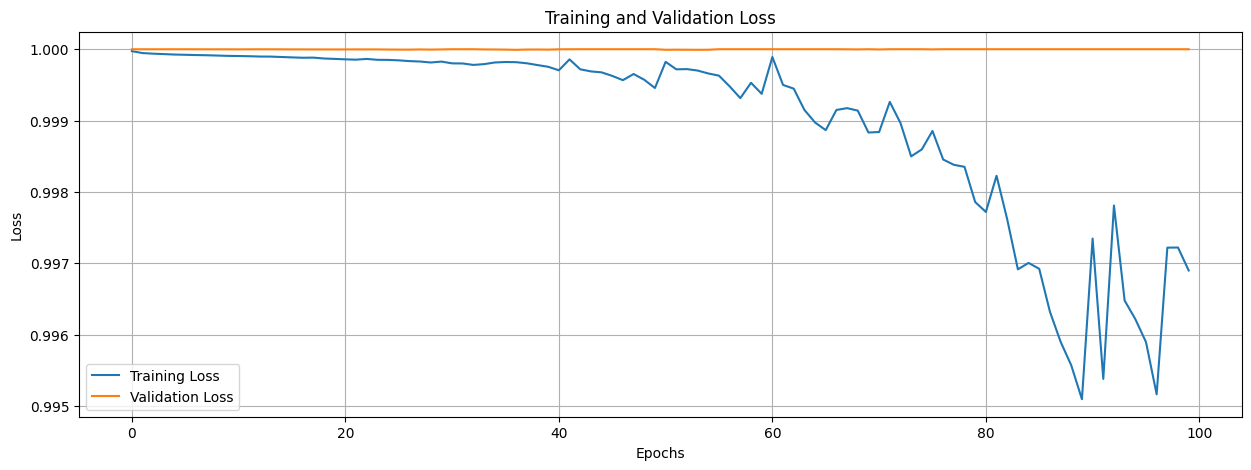

In [32]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

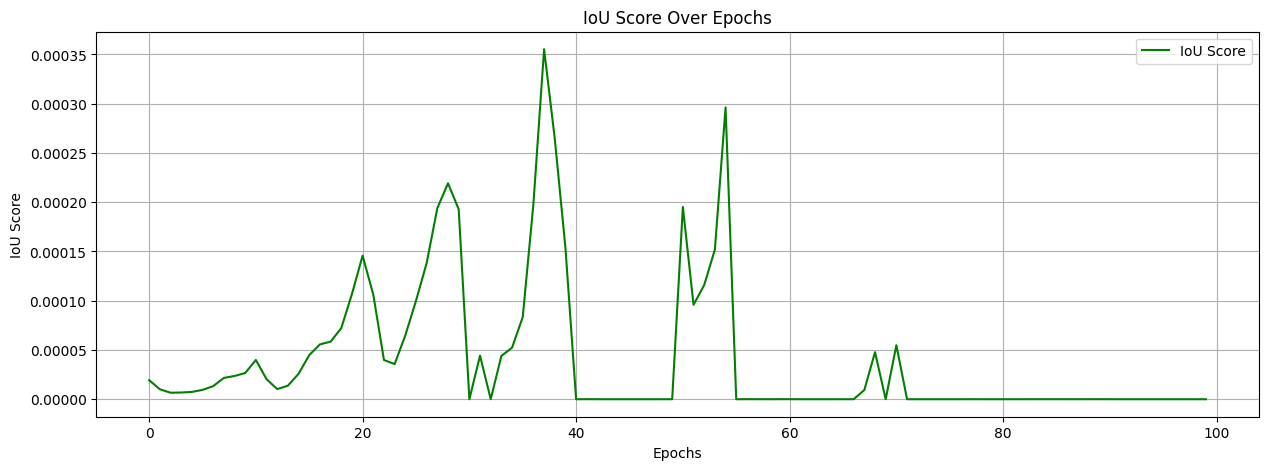

In [33]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()